In [41]:
import torch
import kagglehub
import os
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [42]:
def plot_metrics(loss, accuracy, seq_accuracy=None):

    fig, ax1 = plt.subplots()

    ax1.plot(accuracy, label='Accuracy 1')
    if seq_accuracy is not None:
        ax1.plot(seq_accuracy, label='Accuracy 2')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='y')
    ax1.set_ylim(bottom=0.0)

    ax2 = ax1.twinx()
    ax2.plot(loss, 'r--', label='Loss')
    ax2.set_ylabel('Loss')
    ax2.tick_params(axis='y')

    plt.show()

In [43]:
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri


In [44]:
print(os.listdir(path + '/Dataset/Brain Tumor MRI images'))

['Tumor', 'Healthy', 'MRI image source.txt']


In [45]:
dataset_path = path + '/Dataset'

In [46]:
class MultiModalDataset(Dataset):
    def __init__(self, root1, root2, transform=None, input_size=64):
        self.transform = transform
        self.input_size = input_size

        # Load modality 1
        self.mod1_dataset = ImageFolder(root1)
        self.mod1_samples = self.mod1_dataset.samples  # List of (path, label)

        # Load modality 2
        self.mod2_dataset = ImageFolder(root2)
        self.mod2_samples = self.mod2_dataset.samples

        # Construct unified sample list (same logic as original)
        self.samples = []
        for path, label in self.mod1_samples:
            self.samples.append((path, None, label))
        for path, label in self.mod2_samples:
            self.samples.append((None, path, label))

        # Preload images into memory
        self.image1_cache = {}
        self.image2_cache = {}

        for path, _, label in self.samples:
            if path is not None and path not in self.image1_cache:
                img = Image.open(path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                else:
                    img = transforms.ToTensor()(img)
                self.image1_cache[path] = img
            elif path is None:
                continue

        for _, path, label in self.samples:
            if path is not None and path not in self.image2_cache:
                img = Image.open(path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                else:
                    img = transforms.ToTensor()(img)
                self.image2_cache[path] = img

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path1, path2, label = self.samples[idx]

        if path1 is not None:
            image1 = self.image1_cache[path1]
        else:
            image1 = torch.zeros(3, self.input_size, self.input_size)

        if path2 is not None:
            image2 = self.image2_cache[path2]
        else:
            image2 = torch.zeros(3, self.input_size, self.input_size)

        return image1, image2, label

In [47]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

modalities = [
    'Brain Tumor CT scan Images',
    'Brain Tumor MRI images'
]
classes = ['Tumor', 'Healthy']

modalities_path = [os.path.join(dataset_path, i) for i in modalities]
#print(modalities_path)

In [52]:
dataset = MultiModalDataset(
    modalities_path[0],
    modalities_path[1],
    transform=transform)

dataset.__len__()

9618

In [53]:
from collections import defaultdict

def count_samples(dataset, modalities=['modaliti1', 'modality2'], class_names=None):
    counts = {
        modalities[0]: defaultdict(int),
        modalities[1]: defaultdict(int)
    }

    for img1, img2, label in dataset:
        label_str = class_names[label] if class_names else str(label)

        if img1 is not None:
            counts[modalities[0]][label_str] += 1
        if img2 is not None:
            counts[modalities[1]][label_str] += 1

    return counts

count_samples(dataset, modalities)

{'Brain Tumor CT scan Images': defaultdict(int, {'0': 4300, '1': 5318}),
 'Brain Tumor MRI images': defaultdict(int, {'0': 4300, '1': 5318})}

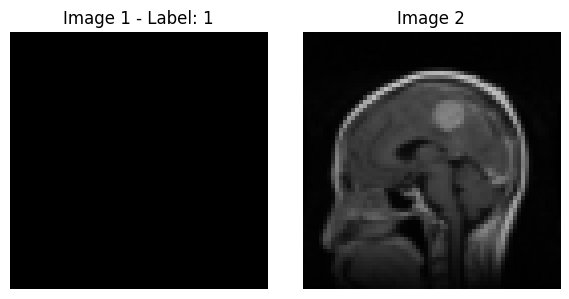

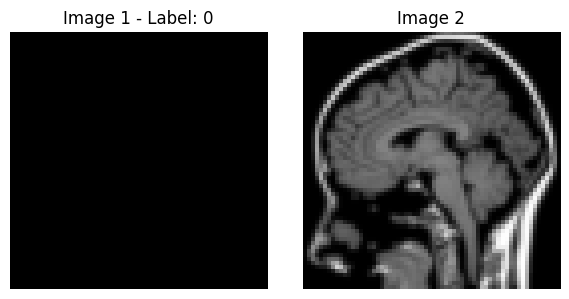

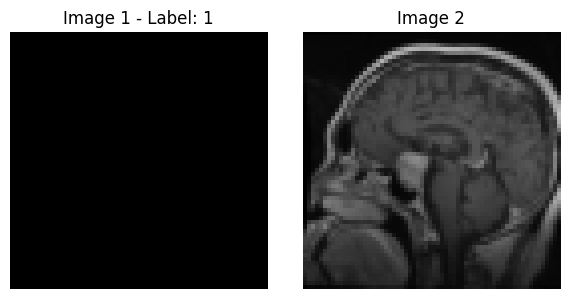

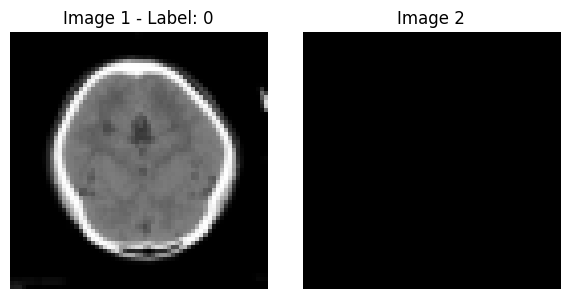

In [54]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Get an iterator from the dataloader
data_iter = iter(dataloader)

# Fetch the first batch
images1, images2, labels = next(data_iter)

# Plot the first 4 samples
for i in range(4):
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(images1[i].permute(1, 2, 0)) if images1[i] is not None else axs[0].set_title("Missing")
    axs[1].imshow(images2[i].permute(1, 2, 0)) if images2[i] is not None else axs[1].set_title("Missing")
    axs[0].set_title(f"Image 1 - Label: {labels[i].item()}")
    axs[1].set_title("Image 2")
    axs[0].axis('off')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

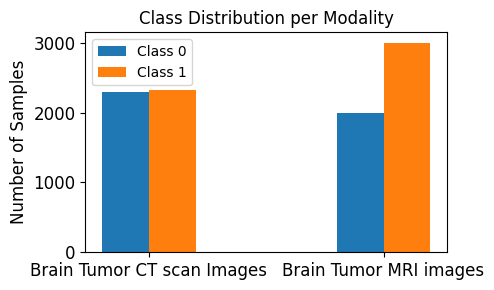

In [ ]:
import matplotlib.pyplot as plt

# Your data
class_counts = {
    'Brain Tumor CT scan Images': {'0': 2300, '1': 2318},
    'Brain Tumor MRI images': {'0': 2000, '1': 3000}
}

modalities = list(class_counts.keys())
classes = sorted(list(set(k for counts in class_counts.values() for k in counts.keys())))

# Prepare bar values
bar_values = {cls: [class_counts[mod].get(cls, 0) for mod in modalities] for cls in classes}
x = range(len(modalities))

# Plot settings
width = 0.2  # narrower bars
fig, ax = plt.subplots(figsize=(5, 3))

for i, cls in enumerate(classes):
    ax.bar(
        [xi + i * width for xi in x],
        bar_values[cls],
        width=width,
        label=f'Class {cls}'
    )

ax.set_xticks([xi + width / (len(classes)) for xi in x])
ax.set_xticklabels(modalities, fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Class Distribution per Modality', fontsize=12)
ax.legend(fontsize=10)
ax.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

# Fusion

In [55]:
class SimpleCNNBranch(nn.Module):
    def __init__(self):
        super(SimpleCNNBranch, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # Input: 3xHxW
            nn.ReLU(),
            nn.MaxPool2d(2),  # H/2 x W/2

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # H/4 x W/4

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape: (64, 1, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return x.view(x.size(0), -1)  # Flatten to (batch_size, 64)

class DualModalitySimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(DualModalitySimpleCNN, self).__init__()
        self.branch1 = SimpleCNNBranch()
        self.branch2 = SimpleCNNBranch()

        self.classifier = nn.Sequential(
            nn.Linear(64 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x1, x2):
        f1 = self.branch1(x1)
        f2 = self.branch2(x2)
        fused = torch.cat((f1, f2), dim=1)
        return self.classifier(fused)

class SingleModalitySimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SingleModalitySimpleCNN, self).__init__()
        self.feature_extractor = SimpleCNNBranch()
        self.classifier = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        return self.classifier(features)

In [56]:
def get_dataloaders(dataset):
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

    return train_loader, test_loader

In [57]:
def train_model(model, dataloader, optimizer, device):

    model.train()
    total_loss = 0.0

    for x1, x2, labels in dataloader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)

        outputs = model(x1, x2)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #break

    return total_loss

def test_model(model, test_loader, device):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x1, x2, labels in test_loader:
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)

            outputs = model(x1, x2)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = DualModalitySimpleCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_loader, test_loader = get_dataloaders(dataset)

accuracy = []
loss = []

for i in tqdm(range(50)):
    train_loss = train_model(model, train_loader, optimizer, device)
    test_acc = test_model(model, test_loader, device)
    loss.append(train_loss)
    accuracy.append(test_acc)

cuda


100%|██████████| 50/50 [01:18<00:00,  1.57s/it]


In [68]:
for i in tqdm(range(20)):
    train_loss = train_model(model, train_loader, optimizer, device)
    test_acc = test_model(model, test_loader, device)
    loss.append(train_loss)
    accuracy.append(test_acc)

100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


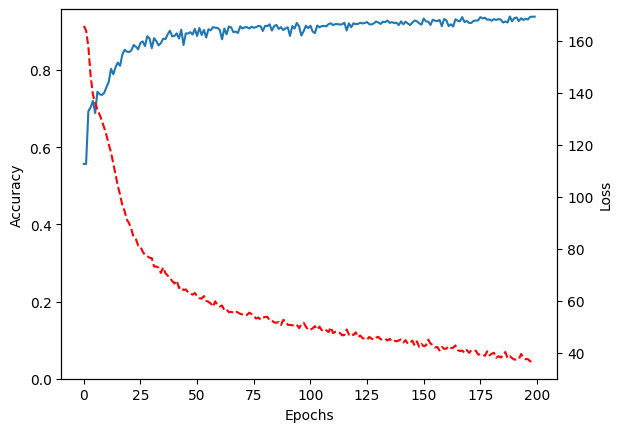

In [69]:
plot_metrics(loss, accuracy)

In [70]:
accuracy[-5:-1]

[0.932952182952183, 0.9308731808731808, 0.9376299376299376, 0.9381496881496881]

# Single for CT

In [71]:
class SingleModalDataset(Dataset):
    def __init__(self, root, transform=None, input_size=64):
        self.transform = transform
        self.input_size = input_size

        # Load dataset structure via ImageFolder
        self.dataset = ImageFolder(root=root)
        self.samples = self.dataset.samples  # list of (path, label)

        # Cache images
        self.image_cache = {}
        for path, label in self.samples:
            if path not in self.image_cache:
                img = Image.open(path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                else:
                    img = transforms.ToTensor()(img)
                self.image_cache[path] = img

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = self.image_cache[path]
        return image, label

In [72]:
modality_path = modalities_path[0]
print(modality_path)

/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images


In [73]:
dataset_1 = SingleModalDataset(modality_path, transform=transform)
train_loader, test_loader = get_dataloaders(dataset_1)

In [74]:
def train_model(model, dataloader, optimizer, device):

    model.train()
    total_loss = 0.0

    for x1, labels in dataloader:
        x1, labels = x1.to(device), labels.to(device)

        outputs = model(x1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss

def test_model(model, test_loader, device):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x1, labels in test_loader:
            x1, labels = x1.to(device), labels.to(device)

            outputs = model(x1)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SingleModalitySimpleCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracy = []
loss = []

for i in tqdm(range(200)):
    train_loss = train_model(model, train_loader, optimizer, device)
    test_acc = test_model(model, test_loader, device)
    loss.append(train_loss)
    accuracy.append(test_acc)

cuda


100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


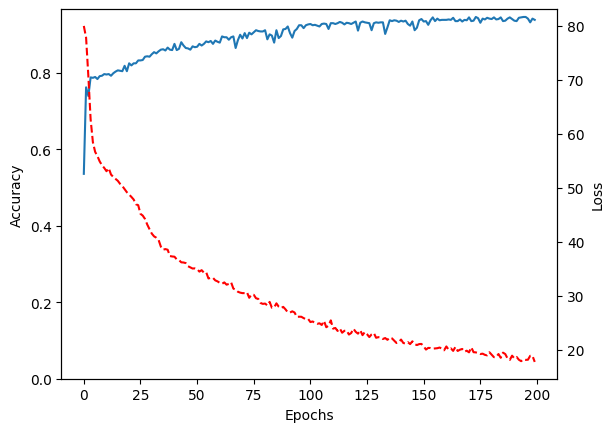

In [76]:
plot_metrics(loss, accuracy)

In [77]:
accuracy[-5:-1]

[0.9458874458874459,
 0.9415584415584416,
 0.9318181818181818,
 0.9415584415584416]

# Single for MRI

In [78]:
modality_path = modalities_path[1]
print(modality_path)

/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images


In [79]:
dataset_1 = SingleModalDataset(modality_path, transform=transform)
train_loader, test_loader = get_dataloaders(dataset_1)

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SingleModalitySimpleCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracy = []
loss = []

for i in tqdm(range(200)):
    train_loss = train_model(model, train_loader, optimizer, device)
    test_acc = test_model(model, test_loader, device)
    loss.append(train_loss)
    accuracy.append(test_acc)

cuda


100%|██████████| 200/200 [01:31<00:00,  2.20it/s]


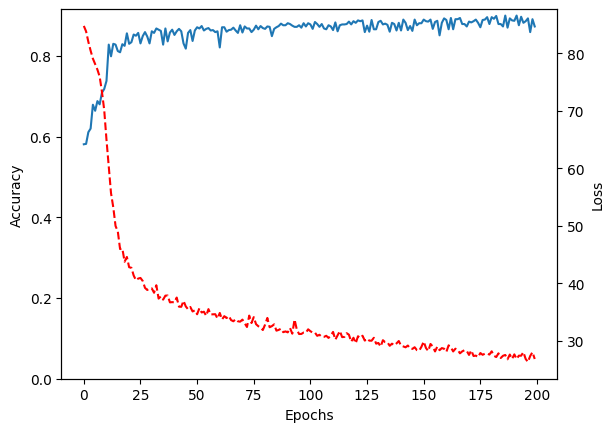

In [82]:
plot_metrics(loss, accuracy)

In [84]:
accuracy[-5:-1]

[0.886, 0.893, 0.859, 0.891]

# Same network

In [85]:
class OneForTwoDataset(Dataset):
    def __init__(self, root1, root2, transform=None, input_size=64):
        self.transform = transform
        self.input_size = input_size

        # Load modality 1
        self.mod1_dataset = ImageFolder(root1)
        self.mod1_samples = self.mod1_dataset.samples  # List of (path, label)

        # Load modality 2
        self.mod2_dataset = ImageFolder(root2)
        self.mod2_samples = self.mod2_dataset.samples

        # Construct unified sample list with modality index
        self.samples = []
        for path, label in self.mod1_samples:
            self.samples.append((path, label, 0))  # 0 for modality 1
        for path, label in self.mod2_samples:
            self.samples.append((path, label, 1))  # 1 for modality 2

        # Preload images into memory
        self.image1_cache = {}
        self.image2_cache = {}

        # Cache images for modality 1
        for path, label in self.mod1_samples:
            if path not in self.image1_cache:
                img = Image.open(path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                else:
                    img = transforms.ToTensor()(img)
                self.image1_cache[path] = img

        # Cache images for modality 2
        for path, label in self.mod2_samples:
            if path not in self.image2_cache:
                img = Image.open(path).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                else:
                    img = transforms.ToTensor()(img)
                self.image2_cache[path] = img


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label, modality_index = self.samples[idx]

        if modality_index == 0:
            image = self.image1_cache[path]
        else:
            image = self.image2_cache[path]

        return image, label

In [86]:
dataset = OneForTwoDataset(
    modalities_path[0], modalities_path[1], transform=transform)
train_loader, test_loader = get_dataloaders(dataset)

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = SingleModalitySimpleCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

accuracy = []
loss = []

for i in tqdm(range(200)):
    train_loss = train_model(model, train_loader, optimizer, device)
    test_acc = test_model(model, test_loader, device)
    loss.append(train_loss)
    accuracy.append(test_acc)

cuda


100%|██████████| 200/200 [02:53<00:00,  1.15it/s]


In [38]:
for i in tqdm(range(100)):
    train_loss = train_model(model, train_loader, optimizer, device)
    test_acc = test_model(model, test_loader, device)
    loss.append(train_loss)
    accuracy.append(test_acc)

100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


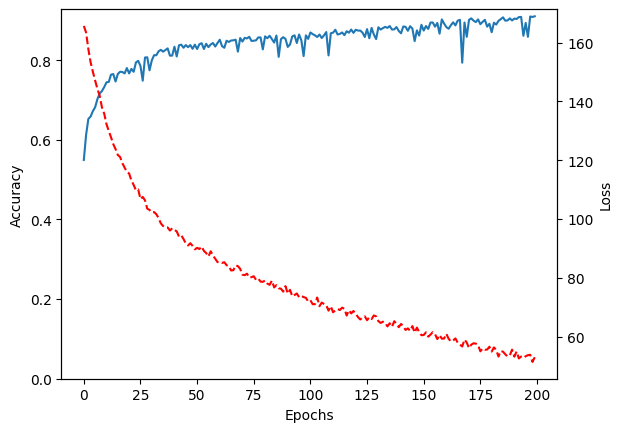

In [88]:
plot_metrics(loss, accuracy)

In [89]:
accuracy[-5:-1]

[0.8934511434511434,
 0.8586278586278586,
 0.9095634095634095,
 0.9085239085239085]